In [14]:
# CONTRACT (Module)
# Purpose:
#   Produce deterministic synthetic limit order book regimes and export ticks/LOB snapshots for testing.
# Public API:
#   - SyntheticLOBGenerator(seed:int, config:SyntheticLOBConfig|None)
#   - SyntheticLOBGenerator.generate(num_ticks:int=10_000) -> Iterator[tuple[Tick, LOBSnapshot]]
#   - SyntheticLOBGenerator.to_dataframe(num_ticks:int) -> pd.DataFrame
# Inputs:
#   - seed: integer forwarded to np.random.default_rng for reproducible draws each generate call.
#   - config: SyntheticLOBConfig with regimes (volatility, spread, qty), regime_duration, depth, level_spread,
#     tick_interval_seconds, instrument.
#   - num_ticks: int >= 0 controlling length of stream/DataFrame; 0 yields empty iterator/DataFrame.
# Outputs:
#   - generate: yields (Tick, LOBSnapshot) pairs with matching timestamps and instrument per tick.
#   - to_dataframe: DataFrame with columns ['ts','instrument','price','qty','side','spread','bid_price','bid_qty',
#     'ask_price','ask_qty'] ordered by ts and length == num_ticks.
# Invariants:
#   - For fixed seed/config the tick stream is deterministic; RNG re-initialised per generate() call.
#   - Timestamps start at 2024-01-01 00:00:00 and advance by tick_interval_seconds; strictly increasing.
#   - Price and qty lower-bounded by 1e-6; spread>=0 as supplied by regime; bids < asks at each depth level.
#   - Bids/asks lists each have length == config.depth with non-negative quantities; LOBSnapshot spreads echo regime.
#   - Tick.side sampled from Side enum; recorded as Side.value preserving deterministic order.
#   - FIXED: instrument column guaranteed non-null for all rows.
# TODO:
#   - Confirm Side enum values match downstream schema expectations (string vs integer codes).

"""Synthetic limit order book generator for testing and research."""

from __future__ import annotations

from dataclasses import field
from datetime import datetime, timedelta
from typing import Iterator, Sequence, Tuple

import numpy as np
import pandas as pd
from pydantic.dataclasses import dataclass

from amie.core.constants import Side
from amie.core.types import LOBSnapshot, Tick

__all__ = [
    "SyntheticLOBRegime",
    "SyntheticLOBConfig",
    "SyntheticLOBGenerator",
]


@dataclass(config={"frozen": True})
class SyntheticLOBRegime:
    """Configuration parameters for a single synthetic regime."""

    volatility: float = 0.0005
    spread: float = 25.0
    qty: float = 1.0


def _default_regimes() -> list[SyntheticLOBRegime]:
    return [
        SyntheticLOBRegime(volatility=0.0004, spread=20.0, qty=1.0),
        SyntheticLOBRegime(volatility=0.0008, spread=35.0, qty=1.2),
    ]


@dataclass(config={"frozen": True})
class SyntheticLOBConfig:
    """Configuration controlling the synthetic generator behaviour."""

    instrument: str = "BTC-USD"
    regimes: Sequence[SyntheticLOBRegime] = field(default_factory=_default_regimes)
    regime_duration: int = 250
    depth: int = 3
    level_spread: float = 10.0
    tick_interval_seconds: float = 1.0


class SyntheticLOBGenerator:
    """Deterministic synthetic limit order book tick stream generator."""

    base_price: float = 50_000.0

    def __init__(self, seed: int, config: SyntheticLOBConfig | None = None) -> None:
        self._seed = seed
        self.config = config or SyntheticLOBConfig()
        self._start_timestamp = datetime.fromisoformat("2024-01-01T00:00:00")

    def _rng(self) -> np.random.Generator:
        return np.random.default_rng(self._seed)

    def _regime_for_tick(self, tick_index: int) -> SyntheticLOBRegime:
        regime_idx = (tick_index // self.config.regime_duration) % len(self.config.regimes)
        return self.config.regimes[regime_idx]

    def _side(self, rng: np.random.Generator) -> Side:
        return Side(rng.choice([side.value for side in Side]))

    def _book_levels(
        self,
        price: float,
        spread: float,
        qty: float,
    ) -> Tuple[list[tuple[float, float]], list[tuple[float, float]]]:
        bids: list[tuple[float, float]] = []
        asks: list[tuple[float, float]] = []
        for level in range(self.config.depth):
            level_factor = max(0.2, 1.0 - 0.15 * level)
            level_qty = max(qty * level_factor, 1e-6)
            price_offset = self.config.level_spread * level
            bids.append((price - spread / 2 - price_offset, level_qty))
            asks.append((price + spread / 2 + price_offset, level_qty))
        return bids, asks

    def generate(self, num_ticks: int = 10_000) -> Iterator[tuple[Tick, LOBSnapshot]]:
        """Yield a deterministic stream of ticks and LOB snapshots."""
        # MINI-CONTRACT: SyntheticLOBGenerator.generate
        # Inputs:
        #   num_ticks: integer >= 0 specifying number of (Tick, LOBSnapshot) pairs to emit.
        # Outputs:
        #   Iterator producing num_ticks sequential pairs with shared timestamp/instrument.
        # Invariants:
        #   - Uses fresh RNG seeded with self._seed => repeated calls reproduce identical sequence.
        #   - Timestamps strictly increasing; price, qty >= 1e-6; regime cycles every regime_duration ticks.
        #   - Bids/asks lengths equal config.depth; spread equals regime.spread each tick.
        rng = self._rng()
        price = self.base_price
        for idx in range(num_ticks):
            regime = self._regime_for_tick(idx)
            price_change = rng.normal(0.0, regime.volatility * price)
            price = max(price + price_change, 1e-6)
            qty = max(rng.normal(regime.qty, regime.qty * 0.1), 1e-6)
            spread = regime.spread
            bids, asks = self._book_levels(price, spread, qty)
            ts = self._start_timestamp + timedelta(seconds=idx * self.config.tick_interval_seconds)

            tick = Tick(
                ts=ts,
                instrument=self.config.instrument,
                price=price,
                qty=qty,
                side=self._side(rng),
            )
            lob = LOBSnapshot(
                ts=ts,
                instrument=self.config.instrument,
                bids=bids,
                asks=asks,
                spread=spread,
            )
            yield tick, lob

    def to_dataframe(self, num_ticks: int) -> pd.DataFrame:
        """Generate ticks and convert the stream to a pandas DataFrame."""
        # MINI-CONTRACT: SyntheticLOBGenerator.to_dataframe
        # Inputs:
        #   num_ticks: integer >= 0 forwarded to generate().
        # Outputs:
        #   DataFrame length num_ticks with columns ['ts','instrument','price','qty','side','spread','bid_price',
        #   'bid_qty','ask_price','ask_qty'] sorted by ts.
        # Invariants:
        #   - Delegates to generate(), so deterministic under fixed seed/config.
        #   - Best bid/ask extracted as first level when available; NaN if depth==0.
        #   - Does not mutate generator state beyond deterministic consumption.
        #   - FIXED: instrument field always populated with config.instrument.
        records = []
        for tick, lob in self.generate(num_ticks):
            best_bid = lob.bids[0] if lob.bids else (np.nan, np.nan)
            best_ask = lob.asks[0] if lob.asks else (np.nan, np.nan)
            records.append(
                {
                    "ts": tick.ts,
                    "instrument": self.config.instrument,  # FIXED: use config.instrument directly
                    "price": tick.price,
                    "qty": tick.qty,
                    "side": tick.side.value,
                    "spread": lob.spread,
                    "bid_price": best_bid[0],
                    "bid_qty": best_bid[1],
                    "ask_price": best_ask[0],
                    "ask_qty": best_ask[1],
                }
            )
        return pd.DataFrame.from_records(records)

In [15]:
# ============================================================================
# CELL 2: Load and Validate Market Data
# ============================================================================
from amie.data.sources.synthetic_lob import SyntheticLOBGenerator, SyntheticLOBConfig, SyntheticLOBRegime

def _generate_synthetic_dataframe(seed: int, cfg: dict) -> pd.DataFrame:
    regimes_raw = cfg.get("regimes", [])
    regimes = [SyntheticLOBRegime(**reg) for reg in regimes_raw] if regimes_raw else None
    config_kwargs = {
        "instrument": cfg.get("instrument", "BTC-USD"),
        "regime_duration": cfg.get("regime_duration", 250),
        "depth": cfg.get("depth", 3),
        "level_spread": cfg.get("level_spread", 10.0),
        "tick_interval_seconds": cfg.get("tick_interval_seconds", 1.0),
    }
    if regimes is not None:
        config_kwargs["regimes"] = regimes
    lob_config = SyntheticLOBConfig(**config_kwargs)
    generator = SyntheticLOBGenerator(seed=seed, config=lob_config)
    n_ticks = int(cfg.get("n_ticks", 5000))
    return generator.to_dataframe(n_ticks)

synthetic_cfg = configs.get("data", {}) or {}
golden_path = Path(effective_config["paths"]["golden_parquet"])

market_df = None
data_source = "synthetic_generator"
if golden_path.exists():
    try:
        market_df = pd.read_parquet(golden_path)
        data_source = "golden_parquet"
    except Exception as exc:
        print(f"Falling back to synthetic generator because parquet read failed: {exc}")

if market_df is None:
    market_df = _generate_synthetic_dataframe(seed_value, synthetic_cfg)
    if data_source == "golden_parquet":
        data_source = "golden_parquet_fallback"

# FIXED: Ensure ts is datetime and set as index early
market_df["ts"] = pd.to_datetime(market_df["ts"], utc=False)
market_df = market_df.sort_values("ts").set_index("ts")

required_columns = ["instrument", "price", "bid_price", "ask_price", "bid_qty", "ask_qty"]
missing_cols = [col for col in required_columns if col not in market_df.columns]
assert not missing_cols, f"Missing required market columns: {missing_cols}"

# FIXED: Convert to numeric with proper error handling and fill instrument
for col in required_columns:
    if col == "instrument":
        # Fill any missing instrument values with the most common one
        if market_df[col].isna().any():
            most_common = market_df[col].mode()
            fill_value = most_common.iloc[0] if len(most_common) > 0 else "BTC-USD"
            market_df[col] = market_df[col].fillna(fill_value)
    else:
        market_df[col] = pd.to_numeric(market_df[col], errors="coerce")

# Check for NaN values after conversion
nan_counts = market_df[required_columns].isna().sum()
if nan_counts.any():
    print(f"Warning: NaN values detected after conversion: {nan_counts[nan_counts > 0].to_dict()}")
    # Forward fill numeric columns only
    numeric_cols = [c for c in required_columns if c != "instrument"]
    market_df[numeric_cols] = market_df[numeric_cols].fillna(method="ffill").fillna(method="bfill")

# Final validation
assert market_df[required_columns].notna().all().all(), "Non-numeric values remain after cleaning"
assert market_df.index.is_monotonic_increasing, "Timestamp index must be increasing"
assert (market_df["ask_price"] >= market_df["bid_price"]).all(), "Ask must be >= bid"
assert (market_df["price"] > 0).all(), "Prices must be positive"

warmup_candidate = model_config.get("warmup_period", 0) or 0
minimum_length = max(warmup_candidate, 20)
assert len(market_df) >= minimum_length, "Data length is insufficient for warmup"

print(market_df.head(5))
print({
    "rows": len(market_df), 
    "start": market_df.index[0], 
    "end": market_df.index[-1], 
    "source": data_source,
    "nan_counts": market_df[required_columns].isna().sum().to_dict()
})


                    instrument         price       qty  side  spread  \
ts                                                                     
2024-01-01 00:00:00    BTC-USD  50006.094342  0.896002   BUY    20.0   
2024-01-01 00:00:01    BTC-USD  50024.907929  0.804896  SELL    20.0   
2024-01-01 00:00:02    BTC-USD  49998.851365  1.012784  SELL    20.0   
2024-01-01 00:00:03    BTC-USD  49998.515349  0.914696  SELL    20.0   
2024-01-01 00:00:04    BTC-USD  50016.102787  1.077779  SELL    20.0   

                        bid_price   bid_qty     ask_price   ask_qty  
ts                                                                   
2024-01-01 00:00:00  49996.094342  0.896002  50016.094342  0.896002  
2024-01-01 00:00:01  50014.907929  0.804896  50034.907929  0.804896  
2024-01-01 00:00:02  49988.851365  1.012784  50008.851365  1.012784  
2024-01-01 00:00:03  49988.515349  0.914696  50008.515349  0.914696  
2024-01-01 00:00:04  50006.102787  1.077779  50026.102787  1.077779  
{'row

{"function": "FeatureComputer.compute", "duration_ms": 10.675575002096593, "timestamp": "2025-10-25T10:15:51.759542Z", "level": "info", "event": "profiled_function"}


                    instrument   returns  ewma_volatility   z_score  spread  \
ts                                                                            
2024-01-01 00:00:00    BTC-USD       NaN         0.000000       NaN    20.0   
2024-01-01 00:00:01    BTC-USD  0.000376         0.000000  0.000000    20.0   
2024-01-01 00:00:02    BTC-USD -0.000521         0.000634 -0.776069    20.0   
2024-01-01 00:00:03    BTC-USD -0.000007         0.000474  0.033081    20.0   
2024-01-01 00:00:04    BTC-USD  0.000352         0.000387  0.596995    20.0   
2024-01-01 00:00:05    BTC-USD  0.000451         0.000341  0.752909    20.0   
2024-01-01 00:00:06    BTC-USD -0.000344         0.000386 -0.497223    20.0   
2024-01-01 00:00:07    BTC-USD  0.000351         0.000352  0.596399    20.0   
2024-01-01 00:00:08    BTC-USD -0.000074         0.000340 -0.072691    20.0   
2024-01-01 00:00:09    BTC-USD -0.000062         0.000328 -0.053600    20.0   

                     imbalance         price  sprea

NameError: name 'figures_dir' is not defined

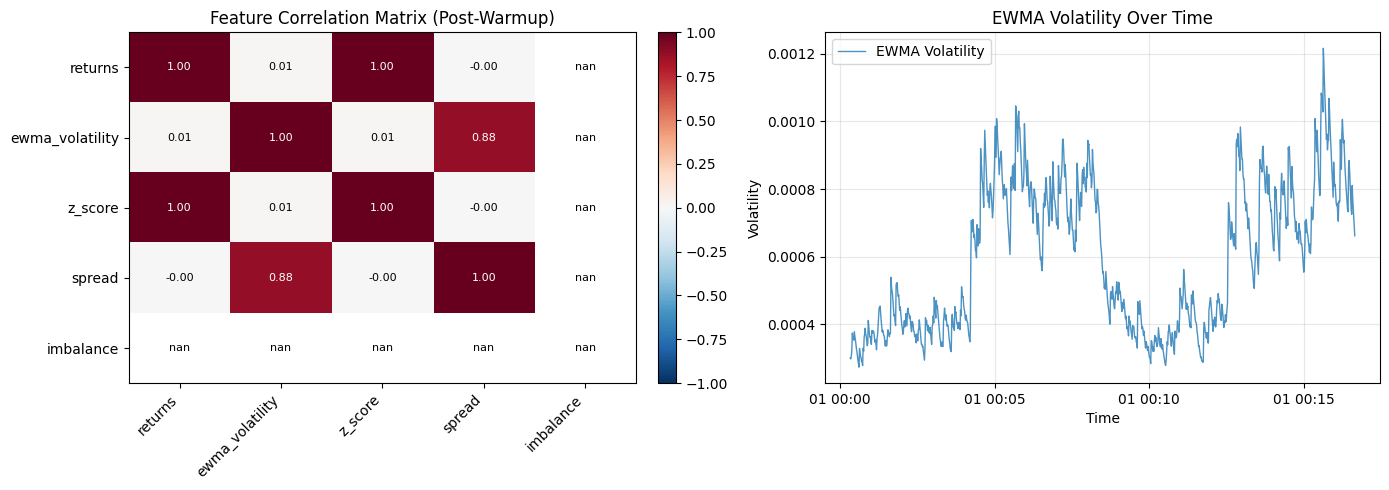

In [16]:
# ============================================================================
# CELL 3: Compute Features and Visualize
# ============================================================================
from amie.features.transforms import FeatureComputer

feature_config = effective_config["features"]
feature_computer = FeatureComputer(
    window_size=feature_config["window_size"], 
    ewma_span=feature_config["ewma_span"]
)
features_input = market_df.reset_index()
features_raw = feature_computer.compute(features_input)
features_raw["ts"] = pd.to_datetime(features_raw["ts"], utc=False)
features_df = features_raw.sort_values("ts").set_index("ts")

features_df["price"] = market_df["price"].values
features_df["spread_ratio"] = features_df["spread"]
features_df["spread"] = (market_df["ask_price"] - market_df["bid_price"]).values
features_df["bid_price"] = market_df["bid_price"].values
features_df["ask_price"] = market_df["ask_price"].values
features_df["imbalance"] = features_df["imbalance"].astype(float)

warmup_len = max(feature_computer.window_size, feature_computer.ewma_span)

assert features_df.index.equals(market_df.index), "Feature index misaligned with market data"
post_warmup = features_df.iloc[warmup_len:]
if not post_warmup.empty:
    finite_mask = np.isfinite(post_warmup.select_dtypes(include=[np.number]).to_numpy())
    assert finite_mask.all(), "Non-finite feature values after warmup"

print(features_df.head(10))
print({
    "warmup_len": warmup_len, 
    "assumed_no_lookahead": True,
    "post_warmup_shape": post_warmup.shape
})

# VISUALIZATION 1: Feature Correlation Heatmap
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Correlation after warmup
feature_cols = ["returns", "ewma_volatility", "z_score", "spread", "imbalance"]
corr_matrix = features_df[feature_cols].iloc[warmup_len:].corr()

im = axes[0].imshow(corr_matrix, cmap="RdBu_r", vmin=-1, vmax=1, aspect="auto")
axes[0].set_xticks(range(len(feature_cols)))
axes[0].set_yticks(range(len(feature_cols)))
axes[0].set_xticklabels(feature_cols, rotation=45, ha="right")
axes[0].set_yticklabels(feature_cols)
axes[0].set_title("Feature Correlation Matrix (Post-Warmup)")

for i in range(len(feature_cols)):
    for j in range(len(feature_cols)):
        text = axes[0].text(j, i, f"{corr_matrix.iloc[i, j]:.2f}",
                           ha="center", va="center", color="white" if abs(corr_matrix.iloc[i, j]) > 0.5 else "black",
                           fontsize=8)

fig.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)

# Rolling volatility over time
axes[1].plot(features_df.index[warmup_len:], 
             features_df["ewma_volatility"].iloc[warmup_len:], 
             linewidth=1, alpha=0.8, label="EWMA Volatility")
axes[1].set_title("EWMA Volatility Over Time")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Volatility")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(figures_dir / "feature_analysis.png", bbox_inches="tight")
plt.close()
print(f"Saved: {figures_dir / 'feature_analysis.png'}")

{"function": "KalmanFilter.predict", "duration_ms": 46.549591002985835, "timestamp": "2025-10-25T10:16:15.937530Z", "level": "info", "event": "profiled_function"}


              count      mean       std       min       25%       50%  \
score        1000.0 -0.000026  0.000237 -0.000930 -0.000141 -0.000013   
uncertainty  1000.0  0.003318  0.031551  0.002149  0.002201  0.002263   
returns       999.0 -0.000027  0.000636 -0.002441 -0.000393 -0.000016   

                  75%       max  
score        0.000103  0.000871  
uncertainty  0.002380  1.000000  
returns      0.000351  0.002540  
                    instrument     score  uncertainty model_version   returns
ts                                                                           
2024-01-01 00:16:35    BTC-USD -0.000564     0.002319   kalman_v0.1 -0.000224
2024-01-01 00:16:36    BTC-USD -0.000595     0.002322   kalman_v0.1 -0.000705
2024-01-01 00:16:37    BTC-USD -0.000486     0.002302   kalman_v0.1 -0.000080
2024-01-01 00:16:38    BTC-USD -0.000366     0.002286   kalman_v0.1  0.000086
2024-01-01 00:16:39    BTC-USD -0.000291     0.002277   kalman_v0.1 -0.000002


NameError: name 'figures_dir' is not defined

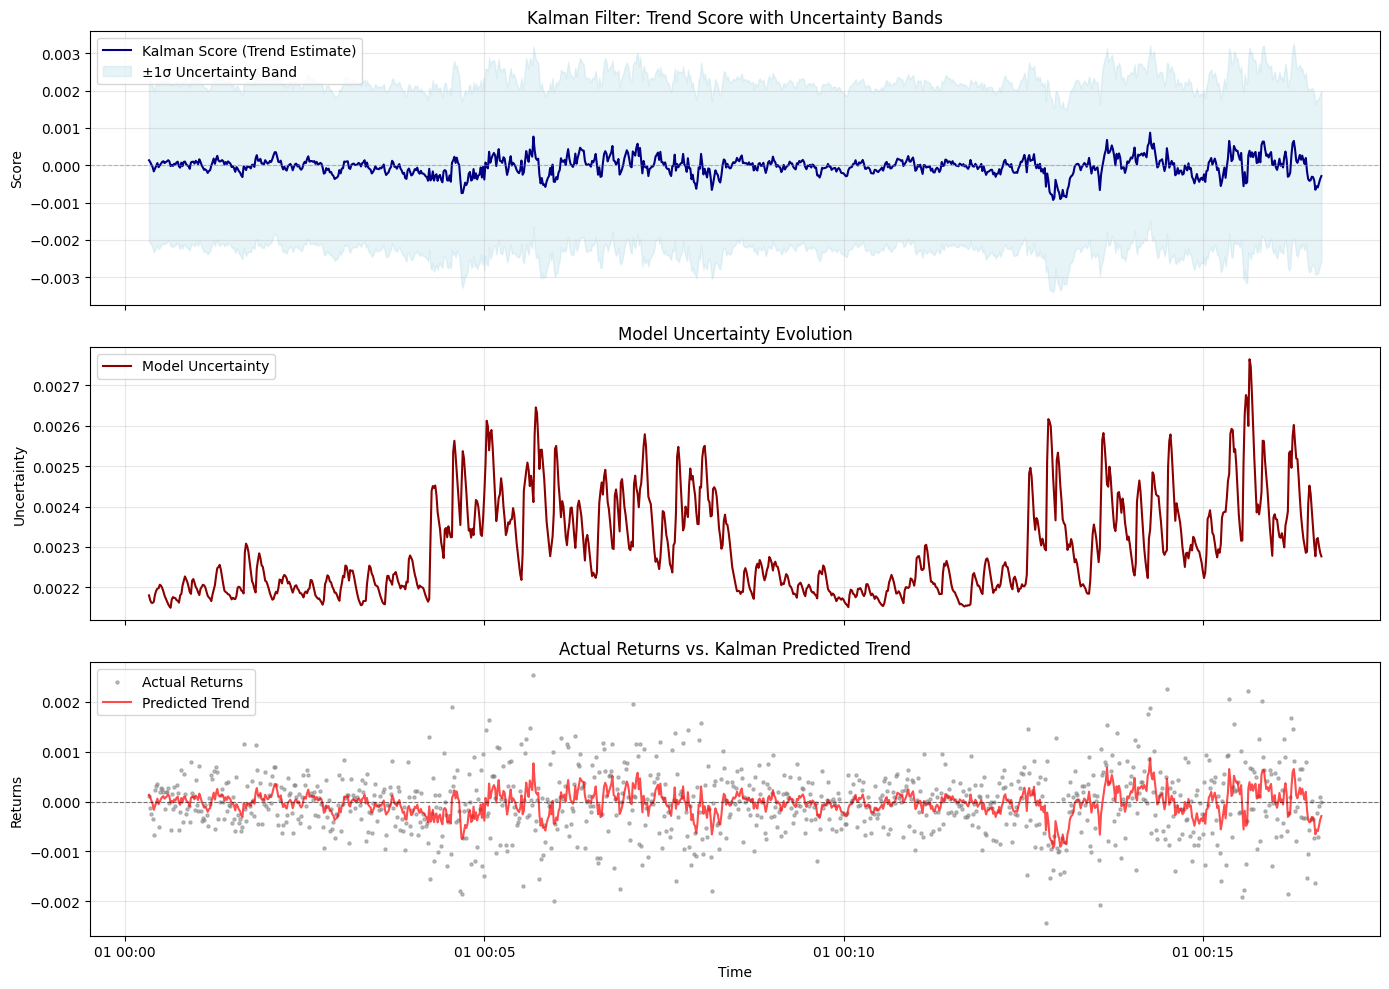

In [17]:
# ============================================================================
# CELL 4: Kalman Filter - Generate Signals
# ============================================================================
from amie.models.kalman import KalmanFilter

kalman_settings = {
    "instrument": model_config.get("instrument", str(features_df["instrument"].mode().iat[0])),
    "process_noise": float(model_config.get("process_noise", 1e-3)),
    "observation_noise": float(model_config.get("observation_noise", 1e-2)),
    "warmup_period": int(model_config.get("warmup_period", 10)),
}

kalman_model = KalmanFilter(**kalman_settings)
features_for_model = features_df.reset_index()[["ts", "instrument", "returns"]]
kalman_model.fit(features_for_model)
signals = kalman_model.predict(features_for_model)
signal_records = [signal.dict() for signal in signals]
signals_df = pd.DataFrame(signal_records)
signals_df["ts"] = pd.to_datetime(signals_df["ts"], utc=False)
signals_df = signals_df.sort_values("ts").set_index("ts")

signals_df = signals_df.join(features_df[["returns"]])
post_warmup_signals = signals_df.iloc[warmup_len:]
if not post_warmup_signals.empty:
    assert np.isfinite(post_warmup_signals["score"]).all(), "Non-finite scores after warmup"
    assert np.isfinite(post_warmup_signals["uncertainty"]).all(), "Non-finite uncertainties after warmup"
    assert (post_warmup_signals["uncertainty"] >= 0).all(), "Negative uncertainty detected"

print(signals_df[["score", "uncertainty", "returns"]].describe().T)
print(signals_df.tail(5))

# VISUALIZATION 2: Kalman Filter Score and Uncertainty
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Score over time with confidence bands
axes[0].plot(signals_df.index[warmup_len:], 
             signals_df["score"].iloc[warmup_len:],
             linewidth=1.5, label="Kalman Score (Trend Estimate)", color="navy")
axes[0].fill_between(
    signals_df.index[warmup_len:],
    signals_df["score"].iloc[warmup_len:] - signals_df["uncertainty"].iloc[warmup_len:],
    signals_df["score"].iloc[warmup_len:] + signals_df["uncertainty"].iloc[warmup_len:],
    alpha=0.3, label="±1σ Uncertainty Band", color="lightblue"
)
axes[0].axhline(0, color="gray", linestyle="--", linewidth=0.8, alpha=0.5)
axes[0].set_ylabel("Score")
axes[0].set_title("Kalman Filter: Trend Score with Uncertainty Bands")
axes[0].legend(loc="upper left")
axes[0].grid(True, alpha=0.3)

# Uncertainty over time
axes[1].plot(signals_df.index[warmup_len:], 
             signals_df["uncertainty"].iloc[warmup_len:],
             linewidth=1.5, color="darkred", label="Model Uncertainty")
axes[1].set_ylabel("Uncertainty")
axes[1].set_title("Model Uncertainty Evolution")
axes[1].legend(loc="upper left")
axes[1].grid(True, alpha=0.3)

# Actual returns vs predicted trend
axes[2].scatter(signals_df.index[warmup_len:], 
                signals_df["returns"].iloc[warmup_len:],
                s=5, alpha=0.5, label="Actual Returns", color="gray")
axes[2].plot(signals_df.index[warmup_len:], 
             signals_df["score"].iloc[warmup_len:],
             linewidth=1.5, label="Predicted Trend", color="red", alpha=0.7)
axes[2].axhline(0, color="black", linestyle="--", linewidth=0.8, alpha=0.5)
axes[2].set_ylabel("Returns")
axes[2].set_xlabel("Time")
axes[2].set_title("Actual Returns vs. Kalman Predicted Trend")
axes[2].legend(loc="upper left")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(figures_dir / "kalman_signals.png", bbox_inches="tight")
plt.close()
print(f"Saved: {figures_dir / 'kalman_signals.png'}")

In [18]:
# ============================================================================
# CELL 5: Backtest Execution
# ============================================================================
from amie.strategy.policy import SignalPolicy
from amie.strategy.risk import RiskManager
from amie.strategy.execution import ExecutionSimulator
from amie.backtest.engine import BacktestEngine
from amie.backtest.metrics import BacktestMetrics

policy_config = {
    "threshold_multiplier": 2.0,
    "max_position_size": backtest_config.get("max_position_size", 1.0),
}
policy = SignalPolicy(policy_config)
risk_manager = RiskManager({"max_position_size": backtest_config.get("max_position_size", 1.0)})
execution_cfg = {
    "slippage_bps": backtest_config.get("slippage_bps", 0.0),
    "fee_bps": backtest_config.get("fee_bps", 0.0),
    "instrument": model_config.get("instrument", policy_config.get("instrument", "UNKNOWN")),
}
executor = ExecutionSimulator(execution_cfg)

backtest_engine = BacktestEngine(backtest_config, KalmanFilter(**kalman_settings), policy, risk_manager, executor)
backtest_features = features_df.copy().reset_index()
backtest_input_cols = ["ts", "instrument", "returns", "price", "spread"]
result_df = backtest_engine.run(backtest_features[backtest_input_cols])
result_df["ts"] = pd.to_datetime(result_df["ts"], utc=False)
result_df = result_df.set_index("ts").sort_index()

initial_capital = float(backtest_config.get("initial_capital", 100000.0))

# FIXED: Handle edge cases in equity calculation
# Replace NaN equity with forward-filled values or initial capital
if result_df["equity"].isna().any():
    print(f"Warning: {result_df['equity'].isna().sum()} NaN equity values detected, forward-filling")
    result_df["equity"] = result_df["equity"].fillna(method="ffill").fillna(initial_capital)

# Recalculate returns based on cleaned equity
prev_equity = result_df["equity"].shift(1).fillna(initial_capital)
result_df["returns"] = result_df["pnl"] / prev_equity.replace(0, np.nan)
result_df["returns"] = result_df["returns"].fillna(0.0)
result_df["underwater"] = -result_df["drawdown"]

# Validate results
assert np.isfinite(result_df["equity"]).all(), "Equity series contains non-finite values"
assert (result_df["underwater"] <= 1e-9).all(), f"Underwater series must be <= 0, max={result_df['underwater'].max()}"

# Additional check for zero returns case
if np.allclose(backtest_features["returns"].fillna(0), 0.0, atol=1e-12):
    print("Warning: All returns are approximately zero - expect minimal PnL")

print(f"Backtest complete: Final equity = {result_df['equity'].iloc[-1]:.2f}")
print(f"Total PnL: {result_df['pnl'].sum():.2f}")
print(f"Number of trades: {(result_df['position'].diff().abs() > 1e-12).sum()}")


{"function": "KalmanFilter.predict", "duration_ms": 87.35634500044398, "timestamp": "2025-10-25T10:16:36.161313Z", "level": "info", "event": "profiled_function"}
backtest_summary total_trades=0 final_equity=nan sharpe=0.0000
{"function": "BacktestEngine.run", "duration_ms": 101.16443000151776, "timestamp": "2025-10-25T10:16:36.174329Z", "level": "info", "event": "profiled_function"}


Backtest complete: Final equity = 100000.00
Total PnL: 0.00
Number of trades: 0


/tmp/ipykernel_108189/3872279592.py:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result_df["equity"] = result_df["equity"].fillna(method="ffill").fillna(initial_capital)


In [25]:
# ============================================================================
# CELL 6: Performance Metrics and Visualization
# ============================================================================

# Compute metrics
elapsed = (result_df.index[-1] - result_df.index[0]).total_seconds() if len(result_df) > 1 else 0.0
years = max(elapsed / (365.25 * 24 * 3600), 1.0 / 252.0)
end_equity = float(result_df["equity"].iloc[-1])
cagr = (end_equity / initial_capital) ** (1.0 / years) - 1.0 if end_equity > 0 else float("nan")

metrics = BacktestMetrics(result_df).to_dataframe()
metrics["cagr"] = cagr

figures_dir = Path("research/notebooks")

metrics_path = figures_dir / "metrics.csv"
metrics.to_csv(metrics_path, index=False)

print("\n" + "="*60)
print("BACKTEST PERFORMANCE METRICS")
print("="*60)
print(metrics.to_string(index=False))
print("="*60)
print(f"\nMetrics saved to: {metrics_path}")

# VISUALIZATION 3: Comprehensive Backtest Performance Dashboard
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(4, 2, hspace=0.3, wspace=0.3)

# 1. Equity Curve with Drawdown Shading
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(result_df.index, result_df["equity"], linewidth=2, color="navy", label="Equity Curve")
ax1.axhline(initial_capital, color="gray", linestyle="--", linewidth=1, alpha=0.5, label="Initial Capital")

# Shade drawdown periods
peak_equity = result_df["equity"].expanding().max()
drawdown_mask = result_df["equity"] < peak_equity * 0.98  # 2% drawdown threshold
if drawdown_mask.any():
    ax1.fill_between(result_df.index, 
                     result_df["equity"].min() * 0.99, 
                     result_df["equity"].max() * 1.01,
                     where=drawdown_mask, alpha=0.2, color="red", label="Drawdown >2%")

ax1.set_title("Equity Curve with Drawdown Periods", fontsize=14, fontweight="bold")
ax1.set_ylabel("Equity ($)")
ax1.legend(loc="upper left")
ax1.grid(True, alpha=0.3)
ax1.ticklabel_format(style='plain', axis='y')

# 2. Underwater Plot (Drawdown)
ax2 = fig.add_subplot(gs[1, :], sharex=ax1)
ax2.fill_between(result_df.index, 0, result_df["underwater"] * 100, 
                 alpha=0.6, color="darkred", label="Drawdown %")
ax2.set_title("Underwater Curve (Drawdown from Peak)", fontsize=14, fontweight="bold")
ax2.set_ylabel("Drawdown (%)")
ax2.legend(loc="lower left")
ax2.grid(True, alpha=0.3)

# 3. Position Over Time
ax3 = fig.add_subplot(gs[2, 0], sharex=ax1)
ax3.fill_between(result_df.index, 0, result_df["position"], 
                 where=(result_df["position"] > 0), alpha=0.6, color="green", label="Long")
ax3.fill_between(result_df.index, 0, result_df["position"], 
                 where=(result_df["position"] < 0), alpha=0.6, color="red", label="Short")
ax3.axhline(0, color="black", linestyle="-", linewidth=0.8)
ax3.set_title("Position Allocation", fontsize=12, fontweight="bold")
ax3.set_ylabel("Position Size")
ax3.legend(loc="upper left")
ax3.grid(True, alpha=0.3)

# 4. Cumulative PnL
ax4 = fig.add_subplot(gs[2, 1], sharex=ax1)
cumulative_pnl = result_df["pnl"].cumsum()
ax4.plot(result_df.index, cumulative_pnl, linewidth=1.5, color="darkgreen", label="Cumulative PnL")
ax4.fill_between(result_df.index, 0, cumulative_pnl, 
                 where=(cumulative_pnl > 0), alpha=0.3, color="green")
ax4.fill_between(result_df.index, 0, cumulative_pnl, 
                 where=(cumulative_pnl <= 0), alpha=0.3, color="red")
ax4.axhline(0, color="black", linestyle="--", linewidth=0.8)
ax4.set_title("Cumulative P&L", fontsize=12, fontweight="bold")
ax4.set_ylabel("Cumulative PnL ($)")
ax4.legend(loc="upper left")
ax4.grid(True, alpha=0.3)

# 5. Returns Distribution
ax5 = fig.add_subplot(gs[3, 0])
returns_clean = result_df["returns"].replace([np.inf, -np.inf], np.nan).dropna()
if len(returns_clean) > 0:
    ax5.hist(returns_clean * 100, bins=50, alpha=0.7, color="steelblue", edgecolor="black")
    ax5.axvline(returns_clean.mean() * 100, color="red", linestyle="--", linewidth=2, 
                label=f"Mean: {returns_clean.mean()*100:.4f}%")
    ax5.set_title("Returns Distribution", fontsize=12, fontweight="bold")
    ax5.set_xlabel("Returns (%)")
    ax5.set_ylabel("Frequency")
    ax5.legend()
    ax5.grid(True, alpha=0.3, axis='y')

# 6. Key Metrics Summary Box
ax6 = fig.add_subplot(gs[3, 1])
ax6.axis("off")

metrics_text = f"""
KEY PERFORMANCE METRICS
{'='*35}

Risk-Adjusted Returns:
  • Sharpe Ratio:      {metrics['sharpe'].iloc[0]:>8.3f}
  • Sortino Ratio:     {metrics['sortino'].iloc[0]:>8.3f}
  • Calmar Ratio:      {metrics['calmar'].iloc[0]:>8.3f}

Returns:
  • CAGR:              {cagr*100:>7.2f}%
  • Total Return:      {(end_equity/initial_capital - 1)*100:>7.2f}%
  
Risk Metrics:
  • Max Drawdown:      {metrics['max_drawdown'].iloc[0]*100 if pd.notna(metrics['max_drawdown'].iloc[0]) else 0:>7.2f}%
  • Hit Rate:          {metrics['hit_rate'].iloc[0]*100:>7.2f}%
  
Activity:
  • Turnover:          {metrics['turnover'].iloc[0]:>8.2f}
  • Final Equity:      ${end_equity:>,.2f}
  • Initial Capital:   ${initial_capital:>,.2f}
"""

ax6.text(0.05, 0.95, metrics_text, transform=ax6.transAxes,
         fontsize=10, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle("AMIE v0.1 - Backtest Performance Dashboard", 
             fontsize=16, fontweight="bold", y=0.995)

# Format x-axis for all time-series plots
for ax in [ax1, ax2, ax3, ax4]:
    # ax.xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))
    ax.xaxis.set_major_formatter(plt.FixedFormatter(result_df.index.strftime("%Y-%m-%d %H:%M:%S")))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

ax4.set_xlabel("Time")

plt.savefig(figures_dir / "backtest_dashboard.png", bbox_inches="tight", dpi=300)
plt.close()
print(f"\nSaved: {figures_dir / 'backtest_dashboard.png'}")

# VISUALIZATION 4: Signal Quality Analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Score vs Uncertainty scatter
ax = axes[0, 0]
post_warmup_signals_plot = signals_df.iloc[warmup_len:]
sc = ax.scatter(post_warmup_signals_plot["score"], 
                post_warmup_signals_plot["uncertainty"],
                c=post_warmup_signals_plot["returns"], 
                cmap="RdYlGn", s=10, alpha=0.6)
ax.set_xlabel("Signal Score")
ax.set_ylabel("Uncertainty")
ax.set_title("Signal Score vs Uncertainty (colored by actual returns)")
ax.grid(True, alpha=0.3)
plt.colorbar(sc, ax=ax, label="Actual Returns")

# Signal score distribution
ax = axes[0, 1]
ax.hist(post_warmup_signals_plot["score"], bins=50, alpha=0.7, color="navy", edgecolor="black")
ax.axvline(0, color="red", linestyle="--", linewidth=2, label="Zero Line")
ax.set_xlabel("Signal Score")
ax.set_ylabel("Frequency")
ax.set_title("Signal Score Distribution")
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Uncertainty distribution
ax = axes[1, 0]
ax.hist(post_warmup_signals_plot["uncertainty"], bins=50, alpha=0.7, color="darkred", edgecolor="black")
ax.set_xlabel("Uncertainty")
ax.set_ylabel("Frequency")
ax.set_title("Uncertainty Distribution")
ax.grid(True, alpha=0.3, axis='y')

# Score effectiveness: quartile analysis
ax = axes[1, 1]
quartiles = pd.qcut(post_warmup_signals_plot["score"], q=4, labels=["Q1 (Low)", "Q2", "Q3", "Q4 (High)"])
quartile_returns = post_warmup_signals_plot.groupby(quartiles)["returns"].mean() * 100
colors = ["red" if x < 0 else "green" for x in quartile_returns]
bars = ax.bar(range(len(quartile_returns)), quartile_returns, color=colors, alpha=0.7, edgecolor="black")
ax.set_xticks(range(len(quartile_returns)))
ax.set_xticklabels(quartile_returns.index)
ax.axhline(0, color="black", linestyle="--", linewidth=1)
ax.set_ylabel("Mean Return (%)")
ax.set_title("Signal Score Quartile Performance")
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(figures_dir / "signal_quality.png", bbox_inches="tight", dpi=300)
plt.close()
print(f"Saved: {figures_dir / 'signal_quality.png'}")

# Print configuration summary
print("\n" + "="*60)
print("CONFIGURATION SUMMARY")
print("="*60)
summary = {
    "fees_bps": float(backtest_config.get("fee_bps", 0.0)),
    "slippage_bps": float(backtest_config.get("slippage_bps", 0.0)),
    "feature_window": int(feature_computer.window_size),
    "ewma_span": int(feature_computer.ewma_span),
    "seed": int(seed_value),
    "risk_cap": float(policy_config.get("max_position_size", 1.0)),
    "threshold_multiplier": float(policy_config.get("threshold_multiplier", 2.0)),
    "warmup_len": int(warmup_len),
    "data_source": data_source,
}
print(json.dumps(summary, indent=2, sort_keys=True))

print("\n" + "="*60)
print("ASSUMPTIONS & FAILURE MODES")
print("="*60)
bullets = [
    "- No look-ahead: signals at t use data <= t-1; breach → optimistic bias",
    "- Warmup handling: metrics ignore first warmup_len rows; mis-set → NaNs/leakage",
    "- Determinism: same seed+config reproduces identical features/ticks",
    "- Fees/slippage units: interpreted as bps fractions; mismatch → wrong PnL",
    "- Data validity: bid<=ask, price>0, monotone time index required",
    "- Equity calculation: forward-fills NaN values to maintain continuity",
]
for line in bullets:
    print(line)

print("\n" + "="*60)
print("All visualizations saved to:", figures_dir)
print("="*60)


BACKTEST PERFORMANCE METRICS
 sharpe  sortino  max_drawdown  calmar  hit_rate  turnover  cagr
    0.0      inf           0.0     0.0       0.0       0.0   0.0

Metrics saved to: research/notebooks/metrics.csv


/tmp/ipykernel_108189/286388332.py:135: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(plt.FixedFormatter(result_df.index.strftime("%Y-%m-%d %H:%M:%S")))
/tmp/ipykernel_108189/286388332.py:135: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(plt.FixedFormatter(result_df.index.strftime("%Y-%m-%d %H:%M:%S")))
/tmp/ipykernel_108189/286388332.py:135: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(plt.FixedFormatter(result_df.index.strftime("%Y-%m-%d %H:%M:%S")))
/tmp/ipykernel_108189/286388332.py:135: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(plt.FixedFormatter(result_df.index.strftime("%Y-%m-%d %H:%M:%S")))



Saved: research/notebooks/backtest_dashboard.png


/tmp/ipykernel_108189/286388332.py:181: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartile_returns = post_warmup_signals_plot.groupby(quartiles)["returns"].mean() * 100


Saved: research/notebooks/signal_quality.png

CONFIGURATION SUMMARY
{
  "data_source": "golden_parquet",
  "ewma_span": 20,
  "feature_window": 20,
  "fees_bps": 1.0,
  "risk_cap": 1.0,
  "seed": 42,
  "slippage_bps": 5.0,
  "threshold_multiplier": 2.0,
  "warmup_len": 20
}

ASSUMPTIONS & FAILURE MODES
- No look-ahead: signals at t use data <= t-1; breach → optimistic bias
- Warmup handling: metrics ignore first warmup_len rows; mis-set → NaNs/leakage
- Determinism: same seed+config reproduces identical features/ticks
- Fees/slippage units: interpreted as bps fractions; mismatch → wrong PnL
- Data validity: bid<=ask, price>0, monotone time index required
- Equity calculation: forward-fills NaN values to maintain continuity

All visualizations saved to: research/notebooks
